In [85]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [86]:
bout_frames = 75

In [87]:
dst_dir = "/home/thomas/RatAnalysis/RatClustering/Footshock_Session1_Fixed"

In [88]:
folders = [os.path.join(dst_dir, d) for d in os.listdir(dst_dir) if os.path.isdir(os.path.join(dst_dir, d))]
csvs = []
for folder in folders:
    
    for filename in os.listdir(folder):
        if "pose_void_tone_shock_combined" in filename:
            csvs.append(os.path.join(folder,filename))

dfs = []
for csv in csvs:
    dfs.append(pd.read_csv(csv, index_col=0))

In [89]:

tsne_segments = []
video_ends = [0]
for i, df in enumerate(dfs):
    df['Group'] = df.index // bout_frames

    df = df[df.index < (df['Group'].max() * bout_frames)]

    df = df.reset_index(drop=True)

    df_xy = df.filter(regex='(_x|_y)$')

    new_values = df_xy.values.reshape(-1, len(df_xy.columns) * bout_frames)

    tsne_segments.append(new_values)
    video_ends.append(video_ends[-1] + len(new_values))

    dfs[i] = df
    
tsne_input = np.vstack(tsne_segments)

video_ends.remove(0)


In [90]:
tsne = TSNE(n_components=2, perplexity=30, method='barnes_hut', random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(tsne_input)

num_clusters = 8  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_results)


# Create a DataFrame to hold the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = kmeans_labels


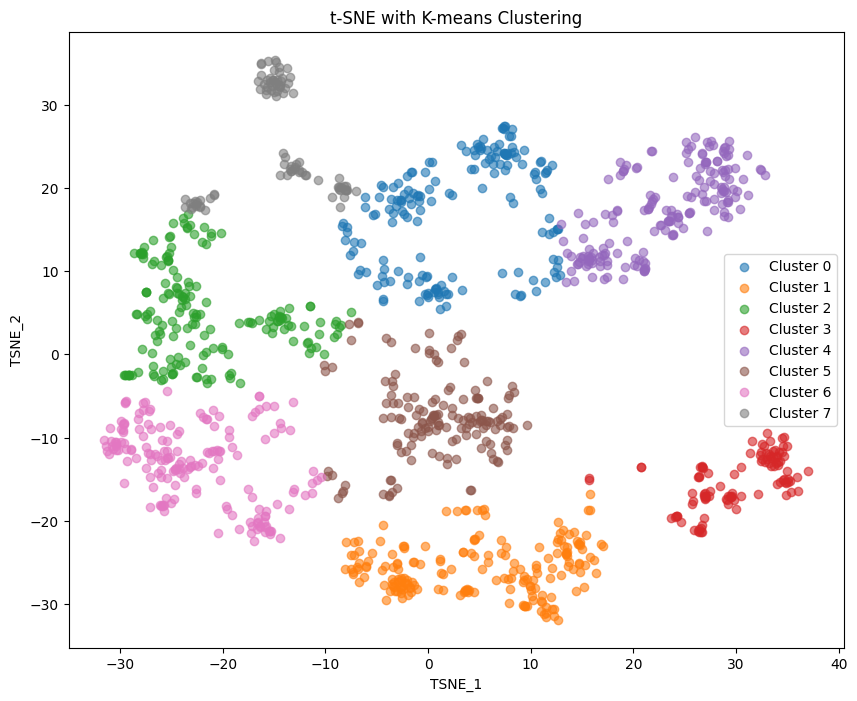

In [91]:
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.title('t-SNE with K-means Clustering')
plt.legend()
plt.show()

In [92]:
array = []
for video, end in enumerate(video_ends):
    if video == 0:
        array.append(kmeans_labels[0:end])
    else:
        array.append(kmeans_labels[video_ends[video-1]:end] )


In [93]:
for df, kmeans in zip(dfs, array):
    df['Cluster'] = np.repeat(kmeans, bout_frames)

In [94]:
grouped_dfs = []
for df in dfs:
    df1 = df.copy()
    df1 = df1.groupby('Group').agg({
        'Is_Voiding': 'max',
        'Shock_Start': 'max',
        'Shock_End': 'max',
        'Tone_Start': 'max',
        'Tone_End': 'max',
        'Seconds': 'mean',
        'Cluster': 'mean'
    }).reset_index()
    grouped_dfs.append(df1)

for i, df in enumerate(grouped_dfs):
    df['Video'] = f'Video {i+1}'
    df['Index'] = df.index
combined_df = pd.concat(grouped_dfs, ignore_index=True)

heatmap_data = combined_df.pivot_table(
    index=['Video'], 
    columns='Group', 
    values='Cluster'
)


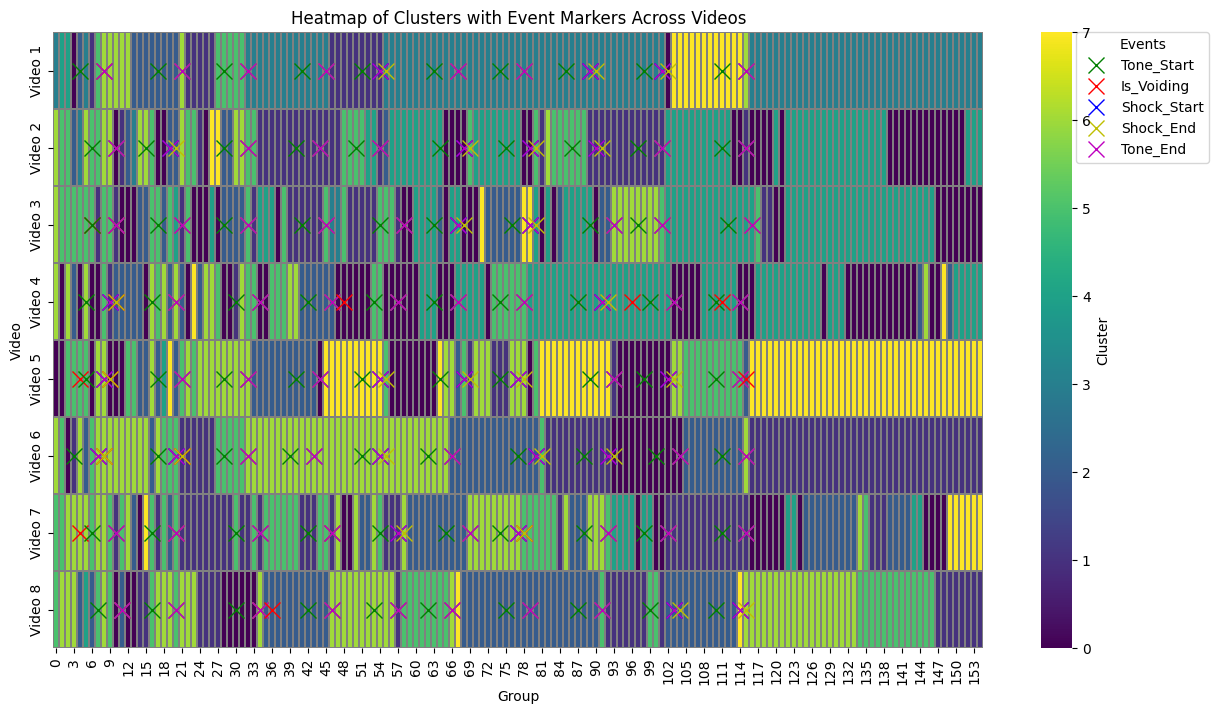

In [95]:

plt.figure(figsize=(15, 8))

ax = sns.heatmap(
    heatmap_data, 
    cmap='viridis', 
    linewidths=0.1, 
    linecolor='gray', 
    cbar_kws={'label': 'Cluster'}
)

for _, row in combined_df.iterrows():
    video_idx = combined_df['Video'].unique().tolist().index(row['Video'])  # Find the video index
    group = row['Group']  # Get the group (x-axis)
    
    # Add 'X' markers at the respective video and group positions
    if row['Is_Voiding']:
        ax.plot(group + 0.5, video_idx + 0.5, 'rx', markersize=12, label='Is_Voiding')
    if row['Shock_Start']:
        ax.plot(group + 0.5, video_idx + 0.5, 'bx', markersize=12, label='Shock_Start')
    if row['Shock_End']:
        ax.plot(group + 0.5, video_idx + 0.5, 'yx', markersize=12, label='Shock_End')
    if row['Tone_Start']:
        ax.plot(group + 0.5, video_idx + 0.5, 'gx', markersize=12, label='Tone_Start')
    if row['Tone_End']:
        ax.plot(group + 0.5, video_idx + 0.5, 'mx', markersize=12, label='Tone_End')

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))

ax.legend(
    unique_labels.values(), 
    unique_labels.keys(), 
    bbox_to_anchor=(1.10, 1),  
    loc='upper left', 
    borderaxespad=0, 
    title='Events'
)
# Adjust labels and title
plt.xlabel('Group')
plt.ylabel('Video')
plt.title('Heatmap of Clusters with Event Markers Across Videos')
plt.show()

In [96]:
for i, df in enumerate(dfs):
    df['Video'] = f'Video {i+1}'
    dfs[i] = df
combined_df = pd.concat(dfs, ignore_index=True)

In [100]:
filtered_df

,RightEar_x,RightEar_y,RightEar_likelihood,LeftEar_x,LeftEar_y,LeftEar_likelihood,forehead_x,forehead_y,forehead_likelihood,Nose_x,...,DateTime,Seconds,Is_Voiding,Shock_Start,Shock_End,Tone_Start,Tone_End,Group,Cluster,Video


In [97]:
filtered_df = combined_df[(combined_df['Cluster'] == 19)]

In [98]:
# grouped = filtered_df.groupby(['Video', 'Group'])

# # Get the maximum number of frames (rows) in the largest group+video combination
# max_frames = max([len(group) for _, group in grouped])
# images = []

# # Iterate over each frame index
# for frame_index in range(max_frames):
#     plt.figure(figsize=(8, 6))

#     for (video, group), group_df in grouped:
#         # Ensure that the group has enough frames (rows)
#         if frame_index < len(group_df):
#             frame = group_df.iloc[frame_index]

#             # Extract (x, y) coordinates
#             right_ear_x, right_ear_y = frame['RightEar_x'], frame['RightEar_y']
#             left_ear_x, left_ear_y = frame['LeftEar_x'], frame['LeftEar_y']
#             forehead_x, forehead_y = frame['forehead_x'], frame['forehead_y']
#             nose_x, nose_y = frame['Nose_x'], frame['Nose_y']

#             # Create a scatter plot for the frame
#             plt.scatter([forehead_x], 
#                         [forehead_y],
#                         c=["Red"])

#     # Set plot title and labels
#     plt.title(f'Video: {video}, Group: {group}, Frame: {frame_index + 1}')
#     plt.xlabel('X-coordinate')
#     plt.ylabel('Y-coordinate')
#     plt.grid(True)

#     image_path = f"./temp/frame_{frame_index}.png"
#     plt.savefig(image_path)
#     images.append(image_path)


In [99]:
max_frames

NameError: name 'max_frames' is not defined